In [1]:
import pandas as pd
import sklearn
import numpy as np
import os
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import metrics

In [2]:
def combine_files(path):
    ''' Given a directory path, gather and return all .csv files within the directory 
        into a dataframe.
    '''
    files = os.listdir(path)

    dfs = []
    for file in files:
        if ".csv" in file:
            file_path = os.path.join(path, file)
            df = pd.read_csv(file_path)
            dfs.append(df)
    data = pd.concat(dfs, ignore_index = True)
    return data

In [3]:
# Gather data - Read data on ozone concentration from 2018 to 2020 into a dataframe
ozone_data1820 = combine_files("Project_Data/Ozone_2018_2020")
ozone_data1820

/var/folders/8x/6lpdt1n14d39lcg9vg6cw7nm0000gn/T/ipykernel_12102/1308620178.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,SITE_ID,DATE_TIME,OZONE,OZONE_F,QA_CODE,UPDATE_DATE
0,ABT147,2020-01-01 00:00:00,24.0,NaN,3,2020-09-24 14:34:30
1,ABT147,2020-01-01 01:00:00,23.0,<,3,2020-09-24 14:34:30
2,ABT147,2020-01-01 02:00:00,NaN,Y,3,2020-09-24 14:34:30
3,ABT147,2020-01-01 03:00:00,23.0,NaN,3,2020-09-24 14:34:30
4,ABT147,2020-01-01 04:00:00,23.0,NaN,3,2020-09-24 14:34:30
...,...,...,...,...,...,...
2563627,ZIO433,2019-12-31 19:00:00,36.0,NaN,3,2020-02-26 16:51:35
2563628,ZIO433,2019-12-31 20:00:00,34.0,NaN,3,2020-02-26 16:51:35
2563629,ZIO433,2019-12-31 21:00:00,32.0,NaN,3,2020-02-26 16:51:35
2563630,ZIO433,2019-12-31 22:00:00,30.0,NaN,3,2020-02-26 16:51:35


In [4]:
# Gather data - Read data on ozone concentration from 2015 to 2017 into a dataframe
ozone_data1517 = combine_files("Project_Data/Ozone_2015_2017")
ozone_data1517

/var/folders/8x/6lpdt1n14d39lcg9vg6cw7nm0000gn/T/ipykernel_12102/1308620178.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,SITE_ID,DATE_TIME,OZONE,OZONE_F,QA_CODE,UPDATE_DATE
0,ABT147,2015-01-01 00:00:00,30.0,NaN,3,2015-01-01 10:15:05
1,ABT147,2015-01-01 01:00:00,29.0,<,3,2015-01-01 10:15:05
2,ABT147,2015-01-01 02:00:00,NaN,B,3,2015-01-01 10:15:05
3,ABT147,2015-01-01 03:00:00,28.0,NaN,3,2015-01-01 10:15:05
4,ABT147,2015-01-01 04:00:00,28.0,NaN,3,2015-01-01 10:15:05
...,...,...,...,...,...,...
2499450,YOS404,2016-12-31 19:00:00,23.0,NaN,3,2017-02-21 13:23:08
2499451,YOS404,2016-12-31 20:00:00,25.0,NaN,3,2017-02-21 13:23:08
2499452,YOS404,2016-12-31 21:00:00,26.0,NaN,3,2017-02-21 13:23:08
2499453,YOS404,2016-12-31 22:00:00,24.0,NaN,3,2017-02-21 13:23:08


In [5]:
# Gather data - read in data on different CASTNET sites where ozone concentration was measured 
sites_data = pd.read_csv("Project_Data/site.csv")

In [6]:
def reference(col, ref_df, ref_id, ref_col):
    ''' Given a column in a dataframe, refer to the reference dataframe at
        the given reference column, and append to a list the corresponding value in the
        row where id in reference dataframe matches id in the original column.
    '''
    lst = []
    for id in col:
        idx = ref_df.index[ref_id == id].tolist()[0]
        lst.append(ref_col[idx])
    return lst

In [7]:
# Get a list of states where ozone concentration was measured
state_lst1517 = reference(ozone_data1517["SITE_ID"], sites_data, sites_data["SITE_ID"], sites_data["STATE"])
state_lst1820 = reference(ozone_data1820["SITE_ID"], sites_data, sites_data["SITE_ID"], sites_data["STATE"])

# Add a state column to the dataframes
ozone_data1517["STATE"] = state_lst1517
ozone_data1820["STATE"] = state_lst1820

In [8]:
# Keep only ozone concentration and state columns in the dataframes
ozone_data1517 = ozone_data1517[["STATE", "OZONE"]]
ozone_data1517 = ozone_data1517.dropna()
ozone_data1820 = ozone_data1820[["STATE", "OZONE"]]
ozone_data1820 = ozone_data1820.dropna()

In [9]:
# Get all the unique sites (dedupe)
states_1517 = set(ozone_data1517["STATE"])
states_1820 = set(ozone_data1820["STATE"])

In [10]:
def extract(lst, df, col):
    ''' Given a list of items, a dataframe, and a column, iterate over the given
        column and see if the value in each row is present in the given list. If yes, 
        append that entire row to a new dataframe.
    '''
    result = []
    for i in range(len(df)):
        if col[i] in lst:
            result.append(df.loc[i])
    result_df = pd.DataFrame(result)
    return result_df

In [338]:
# Gather data - read data for average heart disease mortality rate in 2015-2017 and 2018-2020 in dataframes
mortality_1517 = pd.read_csv("Project_Data/Heart_disease_mortality_2015_2017.csv")
mortality_1820 = pd.read_csv("Project_Data/Heart_disease_mortality_2018_2020.csv")

# Extract heart disease mortality data for the given locations
mortality_data1517 = extract(states_1517, mortality_1517, mortality_1517["LocationAbbr"])
mortality_data1820 = extract(states_1820, mortality_1820, mortality_1820["LocationAbbr"])

# Keep only columns for location and data value (mortality rate)
mortality_data1517 = mortality_data1517[["LocationAbbr", "Data_Value"]]
mortality_data1517 = mortality_data1517.dropna()
mortality_data1820 = mortality_data1820[["LocationAbbr", "Data_Value"]]
mortality_data1820 = mortality_data1820.dropna()

In [12]:
def avg_col(col):
    ''' Given a column, calculate and return the average of that column.
    '''
    lst = list(col)
    avg = sum(lst) / len(lst)
    return avg

In [13]:
def group_avg(col1, col2):
    ''' Given two columns, group the same items in column 1 together and calculate the
        average from its corresponding value in column 2. Return result in a dataframe.
    '''
    list1 = list(col1)
    list2 = list(col2)
    dct = {"item": [], "avg": []}
    unique_items = set(list1)
    for item in unique_items:
        total = 0
        count = 0
        for i in range(len(col1)):
            if col1[i] == item:
                total += col2[i]
                count += 1
        dct["item"].append(item)
        dct["avg"].append(total / count)
    return dct

In [291]:
# Calculate the average mortality rate for each state - 2015-2017
avg = group_avg(mortality_data1517["LocationAbbr"].values, mortality_data1517["Data_Value"].values)
mortality_avg1517 = pd.DataFrame(avg)
mortality_avg1517 = mortality_avg1517.sort_values("item")

# Find out the three states with the highest mortality rate
top_idx = top_highest_idx(mortality_avg1517["avg"])
states_1517 = []
for top in top_idx:
    idx = mortality_avg1517["avg"].index[mortality_avg1517["avg"] == top].tolist()[0]
    states_1517.append(mortality_avg1517["item"][idx])
    
states_1517

['MS', 'AR', 'OK']

In [292]:
# Calculate the average mortality rate for each state - 2018-2020
avg = group_avg(mortality_data1820["LocationAbbr"].values, mortality_data1820["Data_Value"].values)
mortality_avg1820 = pd.DataFrame(avg)
mortality_avg1820 = mortality_avg1820.sort_values("item")

# Find out the three states with the highest mortality rate
top_idx = top_highest_idx(mortality_avg1820["avg"])
states_1820 = []
for top in top_idx:
    idx = mortality_avg1820["avg"].index[mortality_avg1820["avg"] == top].tolist()[0]
    states_1820.append(mortality_avg1820["item"][idx])
    
states_1820

['MS', 'OK', 'AL']

In [16]:
def make_label(col):
    ''' Given a column in a dataframe, compare each value to the average.
        If higher than the average, label as high, otherwise label as low.
    '''
    label = []
    avg = avg_col(col)
    for value in col:
        if value < avg:
            label.append("low")
        if value >= avg:
            label.append("high")
    return label

In [279]:
def top_highest_idx(col, top = 3):
    ''' Given a column and an optional number, find the index top n highest value in the column
        and return in a list.
    '''
    idx = []
    sorted_data = sorted(list(col), reverse = True)
    top = sorted_data[:top]
    return top

In [288]:
# 2015-2017
# Calculate the average ozone concentration for each state
avg1517 = group_avg(list(ozone_data1517["STATE"]), list(ozone_data1517["OZONE"]))
ozone_avg1517 = pd.DataFrame(avg1517)
ozone_avg1517 = ozone_avg1517.sort_values("item")

# Find out the three states with the highest ozone concentration
top_idx = top_highest_idx(ozone_avg1517["avg"])
states_1517 = []
for top in top_idx:
    idx = ozone_avg1517["avg"].index[ozone_avg1517["avg"] == top].tolist()[0]
    states_1517.append(ozone_avg1517["item"][idx])
    
# Make a list of heart disease risk labels of each state based on average mortality rate
label = make_label(mortality_avg1517["avg"])

# Add a risk column with risk labels in the ozone dataframe
ozone_avg1517["risk"] = label
states_1517

['CO', 'NV', 'NM']

In [287]:
# 2018-2020
# Calculate the average ozone concentration for each state
avg1820 = group_avg(list(ozone_data1820["STATE"]), list(ozone_data1820["OZONE"]))
ozone_avg1820 = pd.DataFrame(avg1820)
ozone_avg1820 = ozone_avg1820.sort_values("item")

# Find out the three states with the highest ozone concentration
top_idx = top_highest_idx(ozone_avg1820["avg"])
states_1820 = []
for top in top_idx:
    idx = ozone_avg1820["avg"].index[ozone_avg1820["avg"] == top].tolist()[0]
    states_1820.append(ozone_avg1820["item"][idx])

# Make a list of heart disease risk labels of each state based on average mortality rate
label = make_label(mortality_avg1820["avg"])

# Add a risk column with risk labels in the ozone dataframe
ozone_avg1820["risk"] = label
states_1820

['CO', 'NV', 'AZ']

In [19]:
# Create feature data list using the average ozone concentrations from 2015-2017 and 2018-2020
feature_data = []
for value in ozone_avg1517["avg"]:
    feature_data.append(value)
for value in ozone_avg1820["avg"]:
    feature_data.append(value)

# Create target data list using the labels
target_data = []
for label in ozone_avg1517["risk"]:
    target_data.append(label)
for label in ozone_avg1820["risk"]:
    target_data.append(label)

# Create a dataframe with feature and target for knn classification
all_data = pd.DataFrame({"feature": feature_data, "target": target_data})
all_data

,feature,target
0,32.029072,low
1,32.546681,high
2,23.177158,high
3,42.025180,low
4,40.870979,low
...,...,...
72,34.028907,low
73,19.684996,low
74,31.663105,low
75,24.032292,high


In [20]:
# Normalize data using MinMaxScaler
col = all_data[["feature"]].columns
scaler = MinMaxScaler()
all_data[col] = scaler.fit_transform(all_data[col])
all_data

,feature,target
0,0.476327,low
1,0.496300,high
2,0.134754,high
3,0.862052,low
4,0.817514,low
...,...,...
72,0.553496,low
73,0.000000,low
74,0.462205,low
75,0.167751,high


In [21]:
# Encode risk to 0 and 1
le = LabelEncoder()
all_data["target"] = le.fit_transform(all_data["target"])

In [22]:
def get_scores(k_range, feature, target):
    ''' Given a range of k values, feature, and target data, compute accuracy,
        precision, and recall scores for each k using cross validation. Return
        a dataframe with scores for all k.
    '''
    all_scores = {"k": [], "accuracy": [], "precision": [], "recall": []}
    kf = KFold(n_splits = 10, random_state = 0, shuffle = True)

    for k in list(k_range):
        classifier = KNeighborsClassifier(n_neighbors = k)
        accuracy = np.mean(cross_val_score(classifier, feature, target, cv=kf, scoring='accuracy'))
        precision = np.mean(cross_val_score(classifier, feature, target, cv=kf, scoring='precision'))
        recall = np.mean(cross_val_score(classifier, feature, target, cv=kf, scoring='recall'))
        all_scores["k"].append(k)
        all_scores["accuracy"].append(accuracy)
        all_scores["precision"].append(precision)
        all_scores["recall"].append(recall)

    all_scores = pd.DataFrame(all_scores)
    return all_scores

In [23]:
# Test k values in the range of 4 to 14
k_values = range(4, 15)

# Computation - calculate accuracy, precision, and recall scores for each k
# using cross validation
feature = pd.DataFrame(all_data["feature"])
all_scores = get_scores(k_values, feature, all_data["target"])
all_scores

,k,accuracy,precision,recall
0,4,0.564286,0.806667,0.563810
1,5,0.644643,0.723810,0.817619
2,6,0.528571,0.696667,0.608810
3,7,0.555357,0.639762,0.731667
4,8,0.526786,0.643095,0.677381
5,9,0.516071,0.618333,0.708333
6,10,0.489286,0.626905,0.659762
7,11,0.503571,0.613571,0.688333
8,12,0.464286,0.638333,0.592143
9,13,0.451786,0.610238,0.631429


In [24]:
# Use k value with optimal recall score because in this case, we want to avoid
# the consequence of false negative (a state with ozone concentration at high
# risk level for heart disease but predicted as low risk)
recall_score = list(all_scores["recall"])
opt_idx = recall_score.index(max(recall_score))
opt_k = all_scores["k"][opt_idx]
opt_k

5

In [80]:
def lineplot(k, score, type):
    ''' Given a list of integer (k values), a list of floats (score), and the type of the score (string),
        create and return a lineplot with k values on x-axis and scores on y-axis.
    '''
    sns.lineplot(x = k, y = score, label = type)
    plt.xticks(k)
    plt.title(f"{type} scores for each value of k")
    plt.legend()

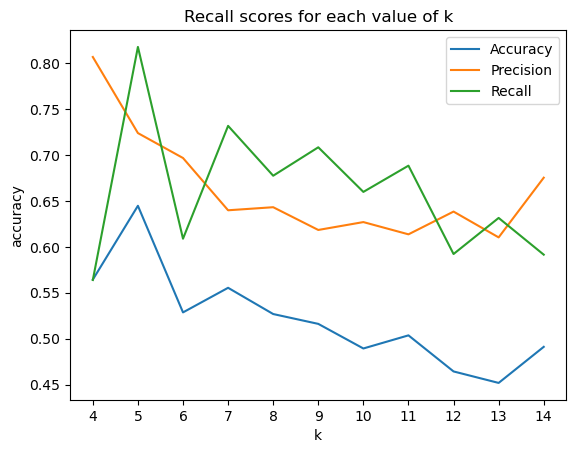

In [81]:
# Create a line plot to justify choice of k value
lineplot(all_scores["k"], all_scores["accuracy"], "Accuracy")
lineplot(all_scores["k"], all_scores["precision"], "Precision")
lineplot(all_scores["k"], all_scores["recall"], "Recall")

In [308]:
# Using the optimal k for recall, predict, based on each state's ozone concentration
# in 2023, whether a state has high, low, or average risk of heart disease mortality

# Gather data - read data for 2023 ozone concentration into a dataframe
ozone_23 = pd.read_csv("Project_Data/ozone_2023.csv")
ozone_23

,SITE_ID,DATE_TIME,OZONE,OZONE_F,QA_CODE,UPDATE_DATE
0,ABT147,2023-01-01 00:00:00,24.0,NaN,3,2023-01-01 01:20:48
1,ABT147,2023-01-01 01:00:00,22.0,<,3,2023-01-01 02:20:45
2,ABT147,2023-01-01 02:00:00,NaN,Y,3,2023-03-31 11:25:41
3,ABT147,2023-01-01 03:00:00,17.0,NaN,3,2023-01-01 04:20:39
4,ABT147,2023-01-01 04:00:00,18.0,NaN,3,2023-01-01 05:20:48
...,...,...,...,...,...,...
778003,ZIO433,2023-11-18 19:00:00,36.0,NaN,1,2023-11-19 14:00:03
778004,ZIO433,2023-11-18 20:00:00,36.0,NaN,1,2023-11-19 14:00:03
778005,ZIO433,2023-11-18 21:00:00,34.0,NaN,1,2023-11-19 14:00:03
778006,ZIO433,2023-11-18 22:00:00,33.0,NaN,1,2023-11-19 14:00:03


In [309]:
# Add state and only keep the ozone concentration value in the dataframe
state_lst = []
for id in ozone_23["SITE_ID"]:
    idx = sites_data.index[sites_data["SITE_ID"] == id].tolist()[0]
    state_lst.append(sites_data["STATE"][idx])
ozone_23["STATE"] = state_lst
ozone_23 = ozone_23[["STATE", "OZONE"]]
ozone_23 = ozone_23.dropna()
ozone_23

,STATE,OZONE
0,CT,24.0
1,CT,22.0
3,CT,17.0
4,CT,18.0
5,CT,18.0
...,...,...
778003,UT,36.0
778004,UT,36.0
778005,UT,34.0
778006,UT,33.0


In [310]:
# Get all the unique sites (dedupe)
states = set(ozone_23["STATE"])

In [311]:
# Calculate the average ozone concentration for each state
o_avg = group_avg(list(ozone_23["STATE"]), list(ozone_23["OZONE"]))
ozone_avg23 = pd.DataFrame(o_avg)
ozone_avg23 = ozone_avg23.sort_values("item")
ozone_avg23

,item,avg
18,AK,30.973417
22,AL,35.223844
7,AR,24.388745
27,AZ,44.118556
4,CA,43.147790
15,CO,46.091055
31,CT,33.355837
1,FL,29.952510
25,GA,34.808795
33,ID,38.375215


In [312]:
# Normalize data using MinMaxScaler
col = ozone_avg23[["avg"]].columns
scaler = MinMaxScaler()
ozone_avg23["norm"] = scaler.fit_transform(ozone_avg23[col])
ozone_avg23

,item,avg,norm
18,AK,30.973417,0.402399
22,AL,35.223844,0.570419
7,AR,24.388745,0.142107
27,AZ,44.118556,0.922027
4,CA,43.147790,0.883653
15,CO,46.091055,1.000000
31,CT,33.355837,0.496576
1,FL,29.952510,0.362043
25,GA,34.808795,0.554012
33,ID,38.375215,0.694993


              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.86      0.75      0.80        16

    accuracy                           0.70        20
   macro avg       0.60      0.62      0.60        20
weighted avg       0.75      0.70      0.72        20



Text(0.5, 1.0, 'Confusion matrix for k value optimal for recall')

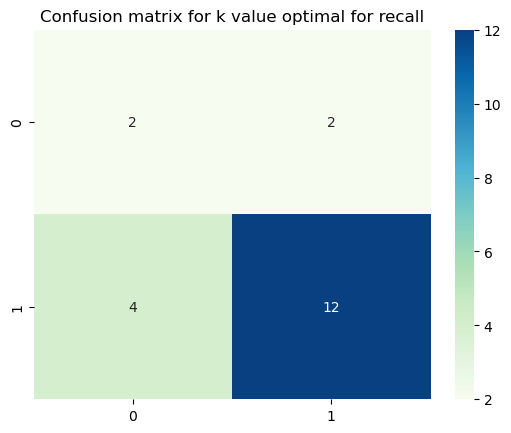

In [340]:
# Predict the level of risk of heart disease using the knn classifier model
# With the k value optimal for recall

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(feature, all_data["target"], random_state = 0)

# Fit knn classifier on the training sets
classifier = KNeighborsClassifier(n_neighbors = opt_k)
classifier.fit(X_train, y_train)

# Predict x_test using the classifier and get f1 score
pred = classifier.predict(X_test)
report = sklearn.metrics.classification_report(y_test, pred)
print(report)

# Create a confusion matrix heatmap
confusion = metrics.confusion_matrix(y_test, pred)
sns.heatmap(confusion, cmap = "GnBu", annot = True, fmt = "g")
plt.title("Confusion matrix for k value optimal for recall")

In [314]:
# Using the k value optimal for recall, predict the level of risk to heart disease mortality
# in each state using ozone concentration in 2023
ozone_23 = pd.DataFrame({"feature": ozone_avg23["norm"]})
predicted = classifier.predict(ozone_23)

# Add label for each predicted data
label_23 = []
for item in predicted:
    if item == 0:
        label_23.append("high")
    if item == 1:
        label_23.append("low")

# Add a risk column to the 2023 dataframe
ozone_avg23["risk"] = label_23
ozone_avg23

,item,avg,norm,risk
18,AK,30.973417,0.402399,low
22,AL,35.223844,0.570419,low
7,AR,24.388745,0.142107,high
27,AZ,44.118556,0.922027,low
4,CA,43.147790,0.883653,low
15,CO,46.091055,1.000000,low
31,CT,33.355837,0.496576,high
1,FL,29.952510,0.362043,low
25,GA,34.808795,0.554012,low
33,ID,38.375215,0.694993,low


In [344]:
# Gather data - Read in .shp file
states = gpd.read_file("Project_Data/Geo_Data/usa-states-census-2014.shp")

In [317]:
# Eliminate duplicated columns by referring to a set of states (dedupe)
states_set = set(states["STUSPS"])

# Get a list of index of unique rows
index = []
for state in states_set:
    idx = states.index[states["STUSPS"] == state].tolist()[0]
    index.append(idx)

# Create a new dataframe with no duplicated state and no District of Columbia
df = []
for i in index:
    df.append(states.loc[i])
states = gpd.GeoDataFrame(df)

In [318]:
def count(col):
    ''' Given a column, count the number of occurrences of each item in the column
        and return the counts in a list.
    '''
    counts = {}
    for item in col:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1
    return counts

In [319]:
def assign_color(col, value1, value2):
    ''' Given a column with two different values, assign a color (red/blue) for each value 
        and return the colors assigned to all values in the column in a list.
    '''
    color = []
    for value in col:
        if value == value1:
            color.append("blue")
        if value == value2:
            color.append("red")
    return color

In [320]:
# Drop the row for Alaska
data_1517 = ozone_avg1517[ozone_avg1517["item"] != "AK"]

# Assign color to each states
color_1517 = assign_color(data_1517["risk"], "low", "high")

# Count the number of states with low/high risk
counts = count(data_1517["risk"])

# Gather the geometry data for states where data was recorded between 2018 and 2020
data_1517 = extract(list(data_1517["item"]), states, states["STUSPS"])
data_1517["color"] = color_1517
geo_1517 = gpd.GeoDataFrame(data_1517, geometry = data_1517["geometry"])
counts

{'high': 14, 'low': 23}

/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500geo_env/lib/python3.11/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Average heart disease mortality rate (per 100,000) between 2015-2017')

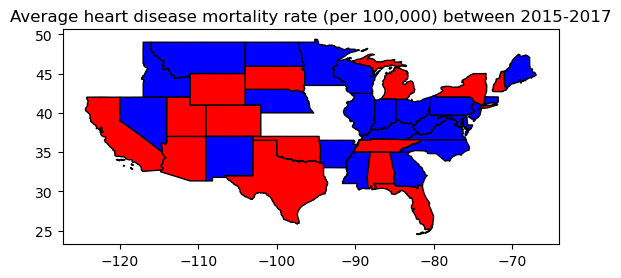

In [336]:
# Plot heart mortality rate data for 2015-2017
geo_1517.plot(color = geo_1517["color"], edgecolor = "black")
plt.title("Average heart disease mortality rate (per 100,000) between 2015-2017")

In [322]:
# Drop the row for Alaska
data_1820 = ozone_avg1820[ozone_avg1820["item"] != "AK"]

# Assign color to each states
color_1820 = assign_color(data_1820["risk"], "low", "high")

# Count the number of states with low/high risk
counts = count(data_1820["risk"])

# Gather the geometry data for states where data was recorded between 2018 and 2020
data_1820 = extract(list(data_1820["item"]), states, states["STUSPS"])
data_1820["color"] = color_1820
geo_1820 = gpd.GeoDataFrame(data_1820, geometry = data_1820["geometry"])
counts

{'high': 16, 'low': 22}

/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500geo_env/lib/python3.11/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Average heart disease mortality rate (per 100,000) between 2018-2020')

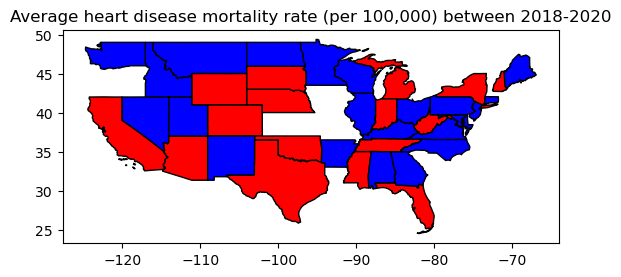

In [335]:
# Plot heart mortality rate data for 2018-2020
geo_1820.plot(color = geo_1820["color"], edgecolor = "black")
plt.title("Average heart disease mortality rate (per 100,000) between 2018-2020")

In [324]:
# Drop the row for Alaska
data_23 = ozone_avg23[ozone_avg23["item"] != "AK"]

# Assign color to each states
color_23 = assign_color(data_23["risk"], "low", "high")

# Count the number of states with low/high risk
counts = count(data_23["risk"])

# Gather the geometry data for states where data was recorded between 2018 and 2020
data_23 = extract(list(data_23["item"]), states, states["STUSPS"])
data_23["color"] = color_23
geo_23 = gpd.GeoDataFrame(data_23, geometry = data_23["geometry"])
counts

{'low': 24, 'high': 12}

/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500geo_env/lib/python3.11/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Average heart disease mortality rate (per 100,000) in 2023')

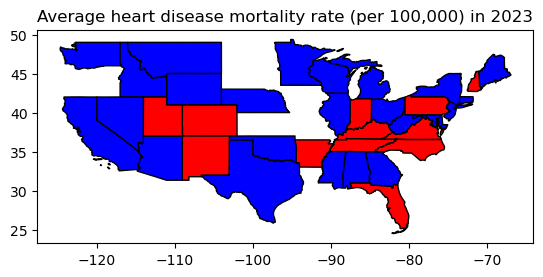

In [334]:
# Plot heart mortality rate data for 2018-2020
geo_23.plot(color = geo_23["color"], edgecolor = "black")
plt.title("Average heart disease mortality rate (per 100,000) in 2023")

In [326]:
# Drop the row for Alaska
data_1517 = ozone_avg1517[ozone_avg1517["item"] != "AK"]

# Gather the geometry data for states where data was recorded between 2015 and 2017
merged_1517 = data_1517.merge(states, how = "left", left_on = "item", right_on = "STUSPS")
merged_1517 = gpd.GeoDataFrame(merged_1517, geometry = merged_1517["geometry"])

/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500geo_env/lib/python3.11/site-packages/geopandas/plotting.py:718: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500geo_env/lib/python3.11/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Average ozone concentration (ppb) between 2015-2017')

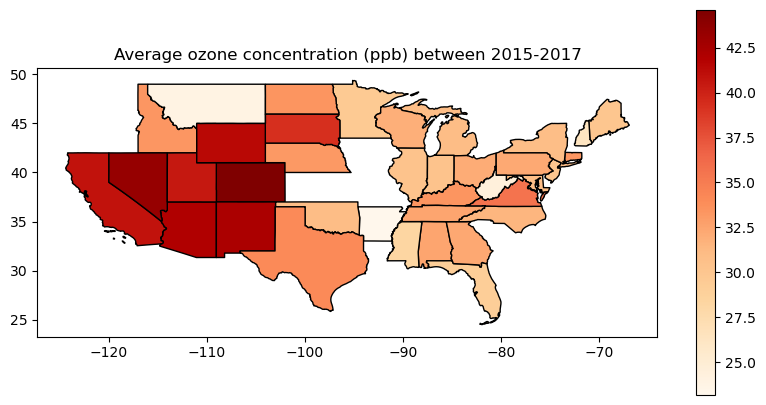

In [327]:
# Plot ozone concentration for 2015-2017
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_1517.plot(column = "avg", cmap = "OrRd", edgecolor = "black", legend = True, legend_kwds = {"shrink": 0.5}, ax = ax)
plt.title("Average ozone concentration (ppb) between 2015-2017")

In [328]:
# Drop the row for Alaska
data_1820 = ozone_avg1820[ozone_avg1820["item"] != "AK"]

# Gather the geometry data for states where data was recorded between 2018 and 2020
merged_1820 = data_1820.merge(states, how = "left", left_on = "item", right_on = "STUSPS")
merged_1820 = gpd.GeoDataFrame(merged_1820, geometry = merged_1820["geometry"])

/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500geo_env/lib/python3.11/site-packages/geopandas/plotting.py:718: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500geo_env/lib/python3.11/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Average ozone concentration (ppb) between 2018-2020')

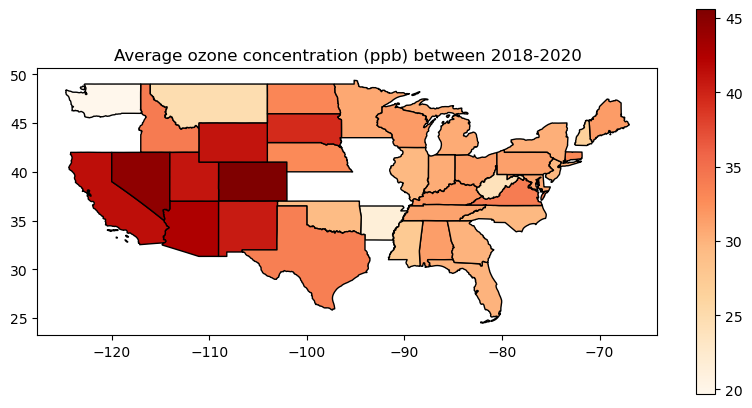

In [329]:
# Plot ozone concentration for 2018-2020
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_1820.plot(column = "avg", cmap = "OrRd", edgecolor = "black", legend = True, legend_kwds = {"shrink": 0.5}, ax = ax)
plt.title("Average ozone concentration (ppb) between 2018-2020")

In [330]:
# Drop the row for Alaska
data_23 = ozone_avg23[ozone_avg23["item"] != "AK"]

# Gather the geometry data for states where data was recorded in 2023
merged_23 = data_23.merge(states, how = "left", left_on = "item", right_on = "STUSPS")
merged_23 = gpd.GeoDataFrame(merged_23, geometry = merged_23["geometry"])

/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500geo_env/lib/python3.11/site-packages/geopandas/plotting.py:718: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/Users/quynhanhnguyen/opt/anaconda3/envs/ds2500geo_env/lib/python3.11/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Average ozone concentration (ppb) in 2023')

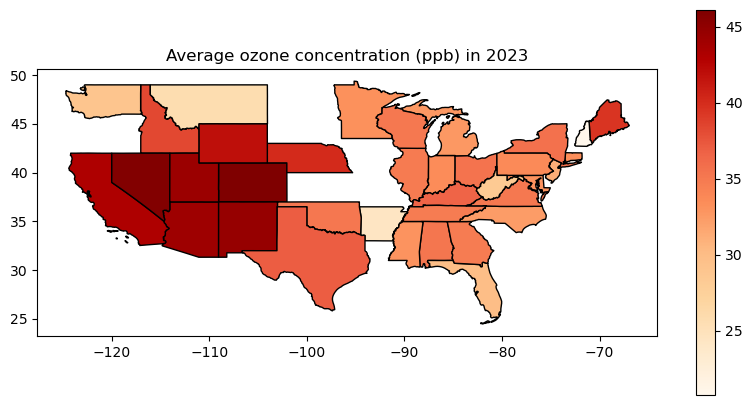

In [333]:
# Plot ozone concentration for 2023
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_23.plot(column = "avg", cmap = "OrRd", edgecolor = "black", legend = True, legend_kwds = {"shrink": 0.5}, ax = ax)
plt.title("Average ozone concentration (ppb) in 2023")

Text(0, 0.5, 'Ozone concentration/ppb')

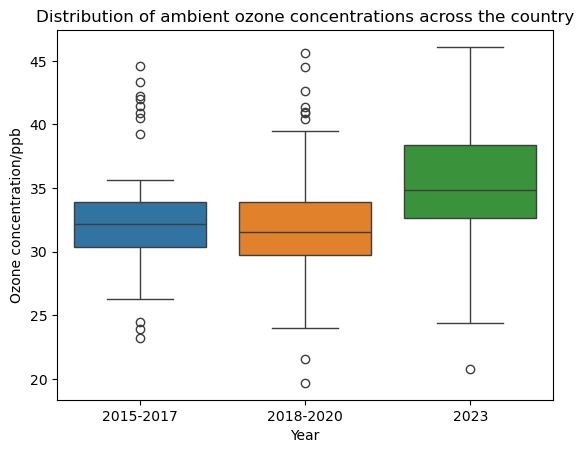

In [332]:
boxplot = pd.DataFrame({"2015-2017": ozone_avg1517["avg"], "2018-2020": ozone_avg1820["avg"], "2023": ozone_avg23["avg"]})
sns.boxplot(data = boxplot)
plt.title("Distribution of ambient ozone concentrations across the country")
plt.xlabel("Year")
plt.ylabel("Ozone concentration/ppb")

In [271]:
def combine_2d(col_lst):
    ''' Given a list of columns, add each value of each column as a list into a bigger list.
        Return everything in a 2d list.
    '''
    lst = []
    for col in col_lst:
        for value in col:
            lst.append([value])
    return lst

In [272]:
# Combine mortality data between 2015 and 2020
mortality_data = combine_2d([mortality_avg1517["avg"], mortality_avg1820["avg"]])

# Normalize all mortality data using MinMaxScaler
scaler = MinMaxScaler()
norm_mortality = scaler.fit_transform(np.array(mortality_data))

In [273]:
# Combine ozone concentration data between 2015 and 2020
ozone_data = combine_2d([ozone_avg1517["avg"], ozone_avg1820["avg"]])

# Normalize all mortality data using MinMaxScaler
scaler = MinMaxScaler()
norm_ozone = scaler.fit_transform(np.array(ozone_data))

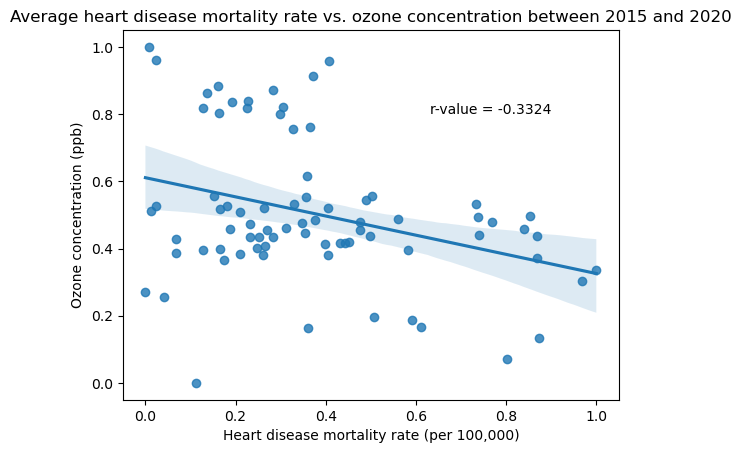

In [274]:
# Generate a linear regression plot and compute r-value for average heart disease mortality rate
# and ozone concentration between 2015 and 2020
sns.regplot(x = norm_mortality, y = norm_ozone)
plt.xlabel("Heart disease mortality rate (per 100,000)")
plt.ylabel("Ozone concentration (ppb)")
plt.title("Average heart disease mortality rate vs. ozone concentration between 2015 and 2020")

# Compute the r-value
corr = statistics.correlation(norm_mortality, norm_ozone)
plt.text(0.9, 0.8, f"r-value = {round(corr, 4)}", horizontalalignment = "right", size = "medium", color = "black")
plt.show()